In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout


In [4]:
con=sqlite3.connect('./FPA_FOD_20170508.sqlite')

df = pd.read_sql_query("SELECT * From Fires", con)


In [5]:
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
#print(cursor.fetchall())
cursor.close()
con.close()

In [ ]:
def to_csv():
    con=sqlite3.connect('./FPA_FOD_20170508.sqlite')

    cursor = con.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    for table_name in tables:
        table_name = table_name[0]
        #if (table_name != 'SpatialIndex' and table_name != 'ElementaryGeometries' and table_name != 'KNN') :
        if (table_name == 'Fires'):
            table = pd.read_sql_query("SELECT * From {}".format(table_name), con)
            table.to_csv(table_name + '.csv', index_label='index')
    cursor.close()
    con.close()

In [5]:
to_csv()

In [6]:
# Remove unwanted cols
df = df.drop(['OBJECTID','STATE', 'COUNTY','FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE_CLASS', 'OWNER_CODE', 'OWNER_DESCR',
       'FIPS_CODE', 'FIPS_NAME', 'Shape', 'DISCOVERY_TIME'], axis=1)

In [7]:
print(df.columns) 
df.head()

Index(['DISCOVERY_DATE', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE', 'FIRE_SIZE',
       'LATITUDE', 'LONGITUDE'],
      dtype='object')


,DISCOVERY_DATE,DISCOVERY_DOY,STAT_CAUSE_CODE,FIRE_SIZE,LATITUDE,LONGITUDE
0,2453403.5,33,9.0,0.10,40.036944,-121.005833
1,2453137.5,133,1.0,0.25,38.933056,-120.404444
2,2453156.5,152,5.0,0.10,38.984167,-120.735556
3,2453184.5,180,1.0,0.10,38.559167,-119.913333
4,2453184.5,180,1.0,0.10,38.559167,-119.933056


In [8]:
# Check for Nan values
df.isnull().values.any()
df1 = df[df.isna().any(axis=1)]
print("Num NAN values: {}".format(df1.shape[0]))

Num NAN values: 0


In [13]:
#Changing pandas dataframe to numpy array
Y = df['FIRE_SIZE'].values
X = np.concatenate( (df['DISCOVERY_DATE'].values.reshape(-1,1),df['DISCOVERY_DOY'].values.reshape(-1,1), 
                     df['STAT_CAUSE_CODE'].values.reshape(-1,1),
                   df['LATITUDE'].values.reshape(-1,1), df['LONGITUDE'].values.reshape(-1,1)), axis = 1 )
print(Y[0:3])
print(X.shape)


[0.1  0.25 0.1 ]
(1880465, 5)


In [14]:
#Normalize the data
sc = StandardScaler()
X = sc.fit_transform(X)

In [16]:
# Shuffles the data before split
# Train/Test split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.5)
print("# Train: {} , #Test: {}".format(X_train.shape[0], X_test.shape[0]))
print("# inputs: {}".format(X_train.shape[1]))
n = X_train.shape[1]

# Train: 940232 , #Test: 940233
# inputs: 5


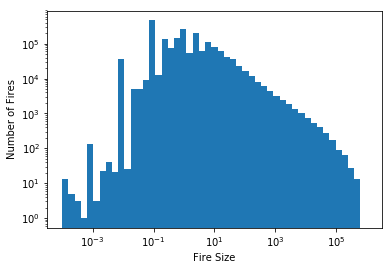

Mean fire size: 74.52015833992388
Median fire size: 1.0
Var in fire size: 6237993.350462397


In [20]:
#Distibution of fire size
plt.hist(Y, bins=np.logspace(-4,6, 50));
plt.ylabel('Number of Fires')
plt.xlabel('Fire Size')
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.savefig("kaggle_fires_dist_log.png")
plt.show()

print("Mean fire size: {}".format(np.mean(Y)))
print("Median fire size: {}".format(np.median(Y)))
print("Var in fire size: {}".format(np.var(Y)))

In [18]:
# Neural network
model = Sequential()
model.add(Dense(32, input_dim=n, kernel_initializer='normal', activation='relu'))
model.add(Dense(64, input_dim=n , activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [19]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [18]:
#Save partly trained model
#model.save('partly_trained.h5')

#Load partly trained model
from keras.models import load_model
#model = load_model('partly_trained.h5')

#Continue training
history = model.fit(X_train, y_train, epochs=10, batch_size=640, verbose = 2, validation_split = 0.1, shuffle=True)

Train on 1523176 samples, validate on 169242 samples
Epoch 1/10
 - 21s - loss: 48.6595 - mse: 48.6595 - mae: 4.9291 - val_loss: 159.8331 - val_mse: 159.8331 - val_mae: 11.9100
Epoch 2/10
 - 21s - loss: 20.4192 - mse: 20.4192 - mae: 3.4406 - val_loss: 133.1046 - val_mse: 133.1046 - val_mae: 10.8512
Epoch 3/10
 - 23s - loss: 15.3836 - mse: 15.3836 - mae: 2.9336 - val_loss: 109.4478 - val_mse: 109.4478 - val_mae: 9.7820
Epoch 4/10
 - 22s - loss: 12.6226 - mse: 12.6226 - mae: 2.5990 - val_loss: 92.5370 - val_mse: 92.5370 - val_mae: 8.9279
Epoch 5/10
 - 22s - loss: 11.2375 - mse: 11.2375 - mae: 2.4050 - val_loss: 87.6749 - val_mse: 87.6748 - val_mae: 8.6104
Epoch 6/10
 - 22s - loss: 10.3881 - mse: 10.3881 - mae: 2.2884 - val_loss: 76.3893 - val_mse: 76.3893 - val_mae: 8.0076
Epoch 7/10
 - 22s - loss: 9.8409 - mse: 9.8409 - mae: 2.2102 - val_loss: 70.1878 - val_mse: 70.1878 - val_mae: 7.5780
Epoch 8/10
 - 23s - loss: 9.4053 - mse: 9.4053 - mae: 2.1467 - val_loss: 63.0735 - val_mse: 63.0735 -

In [18]:
#Save partly trained model
#model.save('partly_trained.h5')

#Load partly trained model
from keras.models import load_model
model = load_model('partly_trained.h5')


_, mse, mae = model.evaluate(X_test, y_test)
print('MSE: %.2f, MAE: %.2f' % (mse,mae))

188047/188047 [==============================] - 4s 20us/step
MSE: 52.54, MAE: 6.25


188047/188047 [==============================] - 3s 16us/step


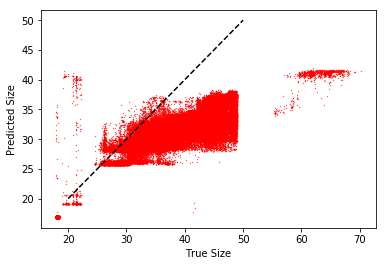

In [27]:
#Visualize some predictions
preds = model.predict(X_test, verbose=1)
plt.scatter(y_test, preds, s=0.3, marker='.', c='r')
plt.xlabel('True Size')
plt.ylabel('Predicted Size')
plt.plot([20,50],[20,50],c='k',linestyle='--')
plt.show()

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

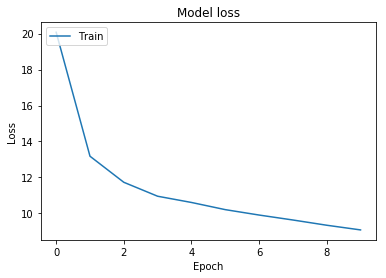

In [99]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
# SVM
from sklearn import svm
from sklearn.metrics import r2_score, mean_absolute_error

n = 70000
svm_reg = svm.SVR(kernel='rbf', degree=3, gamma='auto')
svm_reg.fit(X_train[0:n,:],y_train[0:n].reshape(-1))

y_pred = svm_reg.predict(X_test[0:n,:])

def mean_absolute_percentage_error(y_test, y_pred): 
    return np.mean(np.abs((y_test - y_pred) / (y_test+10e-1)) ) * 100
print("MAE: {}".format(mean_absolute_error(y_test[0:n],y_pred)))
print("MAPE: {}".format(mean_absolute_percentage_error(y_test[0:n],y_pred)))
print("---------------------------------------")


MAE: 52.25358612098635
MAPE: 50.91423004420715
---------------------------------------


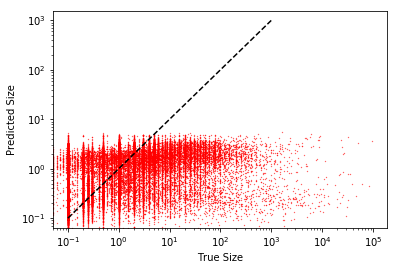

In [21]:
#Visualize svm predictions
plt.scatter(y_test[0:n], y_pred, s=0.3, marker='.', c='r')
plt.xlabel('True Size')
plt.ylabel('Predicted Size')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.plot([.1,20,1000],[.1,20,1000],c='k',linestyle='--')
plt.savefig("kaggle_fires_svm_preds.png")
plt.show()

In [31]:
# SKlearn MLP
from sklearn.neural_network import MLPRegressor

n = 10000

NN = MLPRegressor(hidden_layer_sizes=(800,800,800,800),max_iter=200
                 )

NN.fit(X_train[0:n,:],y_train[0:n].reshape(-1))
y_pred = NN.predict(X_test[0:n,:])

print("MAE: {}".format(mean_absolute_error(y_test[0:n],y_pred)))
print("r2: {}".format(r2_score(y_test[0:n],y_pred)))
print("---------------------------------------")



MAE: 2.9377906768043127
r2: 0.5936004578504975
---------------------------------------


In [39]:
# K Nearest Neighbours
from sklearn.neighbors import KNeighborsRegressor

n = 10000

for nbs in [3,5,10]:
    for wts in ['distance','uniform']:
        K_nn = KNeighborsRegressor(n_neighbors=nbs,
                                   weights=wts,
                                   n_jobs=6)

        K_nn.fit(X_train[0:n,:],y_train[0:n].reshape(-1))
        y_pred = K_nn.predict(X_test[0:n,:])

        print("nbs: {}, wts: {}".format(nbs, wts))
        print("MAE: {}".format(mean_absolute_error(y_test[0:n],y_pred)))
        print("r2: {}".format(r2_score(y_test[0:n],y_pred)))
        print("---------------------------------------")


nbs: 3, wts: distance
MAE: 2.850458582088001
r2: 0.5466271766560886
---------------------------------------
nbs: 3, wts: uniform
MAE: 2.896626296530333
r2: 0.5412828579215408
---------------------------------------
nbs: 5, wts: distance
MAE: 2.8078940836804565
r2: 0.5739384391773825
---------------------------------------
nbs: 5, wts: uniform
MAE: 2.8843075882324003
r2: 0.5603553094200107
---------------------------------------
nbs: 10, wts: distance
MAE: 2.829045443568786
r2: 0.5784726497971278
---------------------------------------
nbs: 10, wts: uniform
MAE: 2.9426652407788003
r2: 0.5520116486941183
---------------------------------------


In [47]:
# Decision Tree
from sklearn import tree

tree_clf = tree.DecisionTreeRegressor(criterion='mae')

tree_clf.fit(X_train[0:n,:],y_train[0:n].reshape(-1))

y_pred = tree_clf.predict(X_test[0:n,:])

print("MAE: {}".format(mean_absolute_error(y_test[0:n],y_pred)))
print("r2: {}".format(r2_score(y_test[0:n],y_pred)))
print("---------------------------------------")


MAE: 3.0811215912115
r2: 0.37784189558739967
---------------------------------------


In [46]:
# Stacked regressors
from mlxtend.regressor import StackingRegressor

n = 10000

estimators = [K_nn, NN, svm_reg]

regStack = StackingRegressor(regressors=estimators,
                             meta_regressor=NN)

regStack.fit(X_train[0:n,:],y_train[0:n].reshape(-1))

y_pred = regStack.predict(X_test[0:n,:])

print("MAE: {}".format(mean_absolute_error(y_test[0:n],y_pred)))
print("r2: {}".format(r2_score(y_test[0:n],y_pred)))
print("---------------------------------------")


MAE: 2.8222310234315002
r2: 0.5813896406600833
---------------------------------------


In [20]:
#Best Features - Univariate statistical selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

feature_names = ['DISCOVERY_DATE', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE', 'LATITUDE', 'LONGITUDE']
bestfeatures = SelectKBest(score_func=f_classif, k=5)
fit = bestfeatures.fit(X,np.array(Y).astype(int))
dfscores = pd.DataFrame(fit.scores_)
df_specs = pd.Series(feature_names).astype(str)
featureScores = pd.concat([df_specs,dfscores],axis=1)
featureScores.columns = ['Feature','f_classif Score'] 
print(featureScores.nlargest(5,'f_classif Score'))  

           Feature  f_classif Score
3         LATITUDE        24.497878
4        LONGITUDE        16.196986
1    DISCOVERY_DOY         6.128625
2  STAT_CAUSE_CODE         4.302896
0   DISCOVERY_DATE         2.265001


/home/ben/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


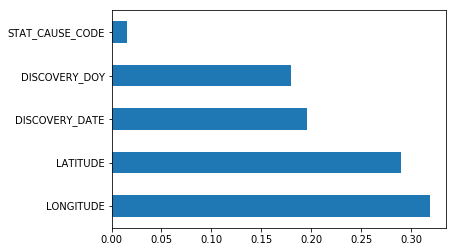

In [21]:
#Best Features - importance
# Feature importance gives you a score for each feature of your data, the higher the score more 
# important or relevant is the feature towards your output variable.
# Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using 
# Extra Tree Classifier for extracting the top 10 features for the dataset.

from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor()
model.fit(X_train,y_train)
feat_importances = pd.Series(model.feature_importances_, index=feature_names)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Index(['DISCOVERY_DATE', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE', 'FIRE_SIZE',
       'LATITUDE', 'LONGITUDE'],
      dtype='object')


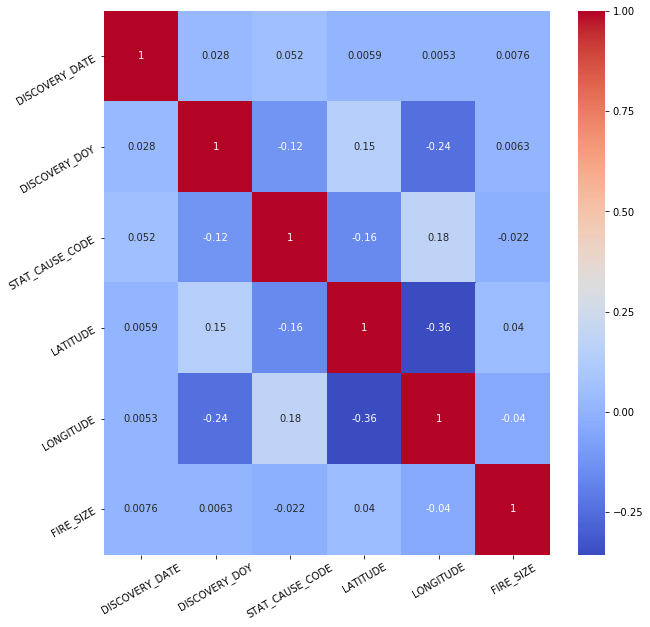

In [26]:
# Best feautres - correlation heatmap
print(df.columns) 
import seaborn as sns
feature_names = ['DISCOVERY_DATE', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE', 'LATITUDE', 'LONGITUDE','FIRE_SIZE']
data = np.concatenate((X_train,y_train.reshape(-1,1)),axis=1)
corrmat = np.corrcoef(data.T)
plt.figure(figsize=(10,10))
g=sns.heatmap(corrmat,annot=True,cmap="coolwarm")
g.set_xticklabels(feature_names,rotation=30)
g.set_yticklabels(feature_names,rotation=30)
plt.show()